In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [3]:
home_df = pd.read_csv(
    "D:\data\home_sensor.csv",
    parse_dates=True,
    index_col='date'
    )

In [4]:
home_df

,ping_ms,temperature_c,humidity_p
date,,,
2021-09-30 21:08:00,17.28,25,35
2021-09-30 21:09:00,17.73,23,40
2021-09-30 21:10:00,18.59,22,41
2021-09-30 21:12:00,16.73,22,42
2021-09-30 21:13:00,18.12,22,42
...,...,...,...
2022-01-10 13:12:00,2000.00,27,28
2022-01-10 13:13:00,2000.00,27,28
2022-01-10 13:14:00,2000.00,27,28


In [5]:
home_df = home_df.drop(['ping_ms', 'temperature_c'], axis = 'columns')
home_df

,humidity_p
date,
2021-09-30 21:08:00,35
2021-09-30 21:09:00,40
2021-09-30 21:10:00,41
2021-09-30 21:12:00,42
2021-09-30 21:13:00,42
...,...
2022-01-10 13:12:00,28
2022-01-10 13:13:00,28
2022-01-10 13:14:00,28


<AxesSubplot:xlabel='date'>

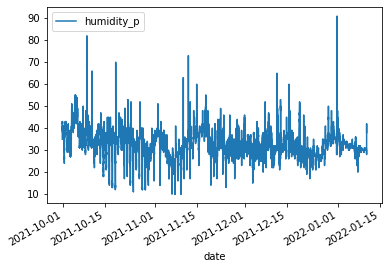

In [6]:
home_df.plot()

#### 데이터 전처리

In [7]:
training_mean = home_df.mean()
training_std = home_df.std()
df_training_value = (home_df - training_mean) / training_std  # z-score 정규화

#### Blocked CV 형식으로 데이터 분할

In [8]:
# Blocked Crossvalidation
TIME_STEPS = 1440  # 1440분 => 1일

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

# AutoEncoder, x=y
x_train = create_sequences(df_training_value.values)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print("Training input shape: ", x_train.shape)

Training input shape:  (128897, 1440, 1)


In [9]:
df_training_value.shape

(130337, 1)

In [10]:
x_train.shape

(128897, 1440, 1)

In [11]:
# CNN 기반 모델
model = keras.Sequential(
    [                         # 1440,                1
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])), # 1140, 1
        # Encoder 시작
        # 요약한 정보를 128차원으로 바꾸고, 7개의 window를 보고, 3개 중에서 pooling을 하겠다.
        # MaxPooling, AveragePooling
        layers.Conv1D(
            filters=128, kernel_size=7, padding="same", strides=3, activation="relu" # 480, 128
        ),
        layers.Dropout(rate=0.2),
        # 요약한 정보를 64차원으로 바꾸고, 7개의 window를 보고, 2개 중에서 pooling을 하겠다
        layers.Conv1D(
            filters=64, kernel_size=7, padding="same", strides=2, activation="relu" # 240, 64
        ),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu" # 120, 32
        ),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu" # 60, 16
        ),   
        layers.Conv1D(
            filters=8, kernel_size=7, padding="same", strides=2, activation="relu" # 30, 8
        ),
        layers.Conv1D(
              filters=4, kernel_size=7, padding="same", strides=2, activation="relu" # 15, 4 <= z vector / Encoder 끝.
          ),
        # Decoder 시작
        layers.Conv1DTranspose(
            filters=8, kernel_size=7, padding="same", strides=2, activation="relu" # 30, 8
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu" # 60, 16
        ),
        layers.Dropout(rate=0.2),
        # 32차원으로 7개의 윈도우를 봐서, stride=2이므로, 시계열이 2배로 확장.
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu" # 120, 32
        ),
          layers.Conv1DTranspose(
            filters=64, kernel_size=7, padding="same", strides=2, activation="relu" # 240, 64
        ),
          layers.Conv1DTranspose(
            filters=128, kernel_size=7, padding="same", strides=2, activation="relu" # 480, 128
        ),     
          layers.Conv1DTranspose(
            filters=128, kernel_size=7, padding="same", strides=3, activation="relu" # 1140, 128
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"), # 1140, 1, 원본 시계열.
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 480, 128)          1024      
                                                                 
 dropout (Dropout)           (None, 480, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 64)           57408     
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           14368     
                                                                 
 conv1d_3 (Conv1D)           (None, 60, 16)            3600      
                                                                 
 conv1d_4 (Conv1D)           (None, 30, 8)             904       
                                                                 
 conv1d_5 (Conv1D)           (None, 15, 4)             2

In [12]:
history = model.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=256
)

Epoch 1/100
504/504 [==============================] - 40s 58ms/step - loss: 0.1248
Epoch 2/100
504/504 [==============================] - 29s 57ms/step - loss: 0.0420
Epoch 3/100
504/504 [==============================] - 28s 56ms/step - loss: 0.0374
Epoch 4/100
504/504 [==============================] - 29s 57ms/step - loss: 0.0335
Epoch 5/100
504/504 [==============================] - 29s 58ms/step - loss: 0.0307
Epoch 6/100
504/504 [==============================] - 29s 58ms/step - loss: 0.0293
Epoch 7/100
504/504 [==============================] - 29s 57ms/step - loss: 0.0285
Epoch 8/100
504/504 [==============================] - 29s 57ms/step - loss: 0.0271
Epoch 9/100
504/504 [==============================] - 29s 57ms/step - loss: 0.0265
Epoch 10/100
504/504 [==============================] - 29s 57ms/step - loss: 0.0260
Epoch 11/100
504/504 [==============================] - 29s 57ms/step - loss: 0.0252
Epoch 12/100
504/504 [==============================] - 29s 57ms/step - lo

In [ ]:
x_train_pred = model.predict(x_train)

4029/4029 [==============================] - 18s 4ms/step


In [ ]:
x_train_pred.shape

(128897, 1440, 1)

#### 학습 데이터를 그대로 복원  => 복원된 데이터와 학습 데이터를 비교

#### 이상치 포함

4029/4029 [==============================] - 18s 4ms/step


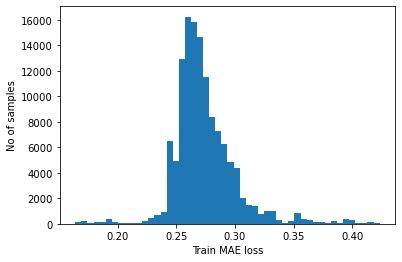

0.2737773610659531
0.026849401172198868
Reconstruction error threshold:  0.3543255645825497


In [ ]:
x_train_pred = model.predict(x_train)
                          # 예측값 각각에 대한 mean absoulte err
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
# threshold = np.max(train_mae_loss) * 1 # 학습 데이터의 최대 에러의 95% 수준보다 넘어가는건 이상치다.
# threshold = np.max(train_mae_loss) * 1.2
mean = np.mean(train_mae_loss)
sigma = np.std(train_mae_loss)
print(mean)
print(sigma)
threshold = mean + (3*sigma)  # 3 sigma 이상일 때 anomaly 라고 취급함
# threshold = 0.4
print("Reconstruction error threshold: ", threshold)

#### 이상치 포함 X

In [ ]:
anomalies = train_mae_loss > threshold # 학습 데이터의 최대 로스보다 큰 로스 값 index
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  2516
Indices of anomaly samples:  (array([46723, 46724, 46725, ..., 51834, 51835, 51836], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64))


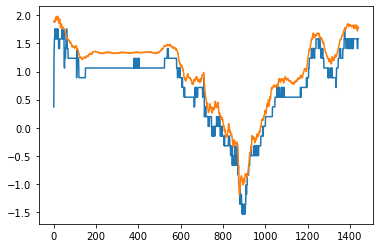

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
df_test_value = (home_df - training_mean) / training_std

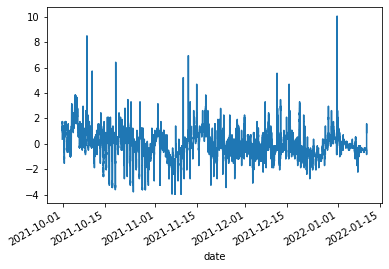

Test input shape:  (128897, 1440, 1)
4029/4029 [==============================] - 20s 5ms/step


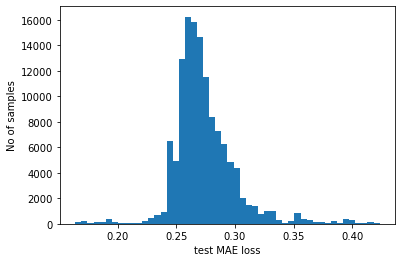

Number of anomaly samples:  2516
Indices of anomaly samples:  (array([46723, 46724, 46725, ..., 51834, 51835, 51836], dtype=int64),)


In [ ]:
df_test_value = (home_df - training_mean) / training_std

fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss_total = np.abs(x_test_pred - x_test)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold # 학습 데이터의 최대 로스보다 큰 로스 값 index
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
test_mae_loss_total

array([[[1.51720591],
        [0.65686546],
        [0.49625696],
        ...,
        [0.39463748],
        [0.19465153],
        [0.18957178]],

       [[0.67534028],
        [0.51221933],
        [0.35178976],
        ...,
        [0.22861783],
        [0.20069699],
        [0.19571643]],

       [[0.52386369],
        [0.36606626],
        [0.37930684],
        ...,
        [0.230511  ],
        [0.20184545],
        [0.19725137]],

       ...,

       [[0.22709439],
        [0.23208688],
        [0.24328927],
        ...,
        [0.29278586],
        [0.27489988],
        [0.3067892 ]],

       [[0.22763977],
        [0.23292366],
        [0.24399758],
        ...,
        [0.28808341],
        [0.26988301],
        [0.30019144]],

       [[0.22998417],
        [0.2353274 ],
        [0.24628348],
        ...,
        [0.38482959],
        [0.37485302],
        [2.02686785]]])

In [ ]:
len(df_test_value)

130337

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [ ]:
anomalous_data_indices

[48162,
 48163,
 48164,
 48165,
 48166,
 48167,
 48168,
 48169,
 48170,
 48171,
 48172,
 48173,
 48174,
 48175,
 48176,
 48177,
 48178,
 48179,
 48180,
 48181,
 48182,
 48183,
 48184,
 48185,
 48186,
 48187,
 48188,
 48189,
 48190,
 48191,
 48192,
 48193,
 48194,
 48195,
 48196,
 48197,
 48198,
 48199,
 48200,
 48201,
 48202,
 48203,
 48204,
 48205,
 48206,
 48207,
 48208,
 48209,
 48210,
 48211,
 48212,
 48213,
 48214,
 48215,
 48216,
 48217,
 48218,
 48219,
 48220,
 48221,
 48222,
 48223,
 48224,
 48225,
 48226,
 48227,
 48228,
 48229,
 48230,
 48231,
 48232,
 48233,
 48234,
 48235,
 48236,
 48237,
 48238,
 48239,
 48240,
 48241,
 48242,
 48243,
 48244,
 48245,
 48246,
 48247,
 48248,
 48249,
 48250,
 48251,
 48252,
 48253,
 48254,
 48255,
 48256,
 48257,
 48258,
 48259,
 48260,
 48261,
 48262,
 48263,
 48264,
 48265,
 48266,
 48267,
 48268,
 48269,
 48270,
 48271,
 48272,
 48273,
 48274,
 48275,
 48276,
 48277,
 48278,
 48279,
 48280,
 48281,
 48282,
 48283,
 48284,
 48285,
 48286,


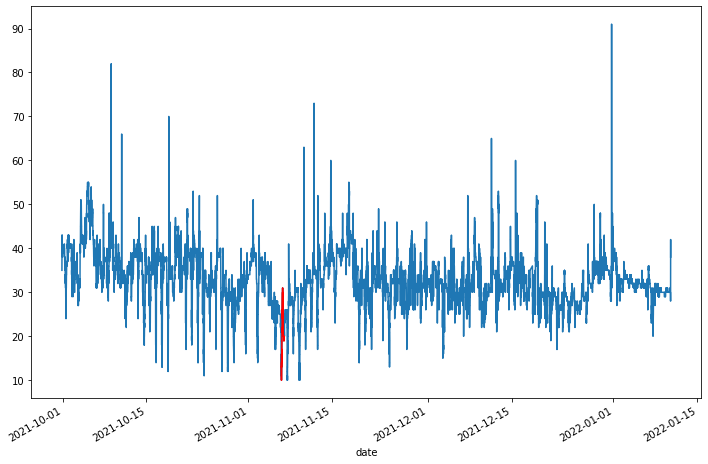

In [ ]:
df_subset = home_df.iloc[anomalous_data_indices]
fig, ax = plt.subplots(figsize=(12, 8))
home_df.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()